In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-02_2021-08-02-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,87502,None,None,61310.941638
2020-06-13,87503,None,None,58146.357512
2020-06-14,87504,None,None,55048.098995
2020-06-15,87505,None,None,52288.897609
2020-06-16,87506,None,None,49818.215498
...,...,...,...,...
2021-07-29,87914,None,None,800663.271292
2021-07-30,87915,None,None,799796.486698
2021-07-31,87916,None,None,794924.836920


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-01_2021-08-01-18-02.pickle


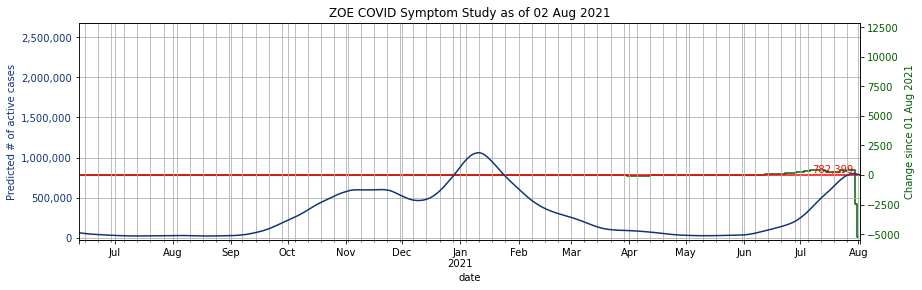

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

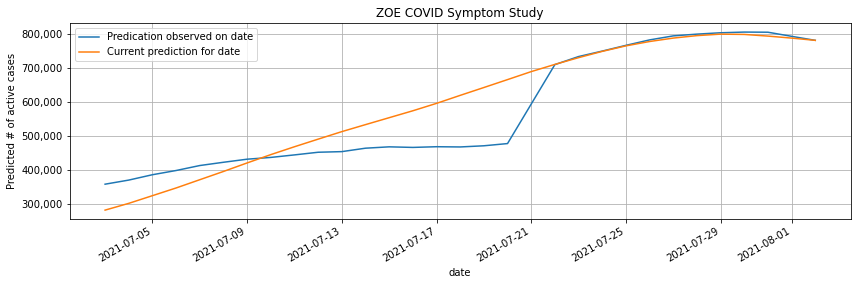

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Mon 02 Aug 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
184,Lincoln,E07000138,9.336919
70,North East Derbyshire,E07000038,4.834958
54,Luton,E06000032,4.032892
100,Erewash,E07000036,3.474822
347,Hammersmith and Fulham,E09000013,3.155061
358,Belfast,N09000003,3.135292
164,Chorley,E07000118,2.899136
380,Waltham Forest,E09000031,2.897098
247,Sheffield,E08000019,2.855955
246,Rotherham,E08000018,2.786923
